In [5]:
import pandas as pd
df = pd.read_csv("Doc\\ipodata.csv")
# df.head()

In [2]:
df["Price"] = df["Price"].str.replace("Rp","").astype(int)
prices = df["Price"]
df["Share"] = df["Share"].str.replace("%","").astype(float)
df["Warran"] = df['Warran'].apply(lambda x: int(x.split(":")[0])/int(x.split(":")[1]) if x != "0" else int(x) )
df["Underwriter"] = df["Underwriter"].apply(lambda x:x.split("-")[0])
df["Amount"] = df["Amount"].str.replace(",","")
df["Amount"] = df["Amount"].str.replace("lot","")
df["Amount"] = df["Amount"].apply(lambda x:int(x))

In [3]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
encoder = LabelEncoder()
# Encode each column
for column in ["Papan Pencatatan","Underwriter","Sector","Subsector"]:
    df[column] = encoder.fit_transform(df[column])

In [4]:
feature_enginering = ["Papan Pencatatan","Share","Underwriter","Warran","Sector","Subsector","Price","Amount"]

In [5]:
x = df[feature_enginering]

In [6]:
target = pd.read_csv("Doc//ipo_gain.csv")
target.head()

,1 candle gain,2 candle gain,3 candle gain,4 candle gain,5 candle gain,1 candle high,2 candle high,3 candle high,4 candle high,5 candle high
0,34.666667,68.000000,109.333333,98.666667,94.666667,34.666667,68.000000,109.333333,161.333333,116.000000
1,35.000000,36.000000,20.000000,20.000000,15.000000,35.000000,51.000000,38.000000,31.000000,21.000000
2,34.313725,80.392157,92.156863,66.666667,76.470588,34.313725,80.392157,123.529412,109.803922,88.235294
3,24.800000,28.000000,52.000000,87.200000,40.800000,24.800000,40.000000,52.000000,88.000000,98.400000
4,24.761905,4.761905,10.476190,16.190476,22.857143,34.285714,28.571429,19.047619,18.095238,22.857143


In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [8]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

In [15]:
def predict(label):
    # Reshape the data for K-Means
    data_reshaped = target[label].values.reshape(-1, 1)
    # Specify the number of clusters
    kmeans = KMeans(n_clusters=4)

    # Fit the model to your data
    kmeans.fit(data_reshaped)

    # Get the cluster labels
    df[f'Cluster_{label}'] = kmeans.labels_

    # To visualize the clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(range(len(data_reshaped)), data_reshaped, c=df[f'Cluster_{label}'], cmap='viridis')

    # Create legend handles
    handles = []
    for cluster in range(kmeans.n_clusters):
        handles.append(mpatches.Patch(color=scatter.cmap(scatter.norm(cluster)), label=f'Cluster {cluster}'))

    # Add the legend
    plt.legend(handles=handles, title='Clusters')

    plt.xlabel('Index')
    plt.ylabel(f'1 candle high{label}')
    plt.title(f'K-Means Clustering on {label} ')
    plt.show()

    y = df[f'Cluster_{label}']
    X = df[feature_enginering]
    attemp = label

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the models and their hyperparameters for tuning
    models = {
        'LogisticRegression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
        'DecisionTree': (DecisionTreeClassifier(), {'max_depth': [3, 5, 10]}),
        'RandomForest': (RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [3, 5, 10]}),
        'SVC': (SVC(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
        'XGBClassifier': (XGBClassifier(), {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [50, 100]})
        }

    # Initialize variables to store the best model
    best_f1 = 0
    best_model = None
    best_model_name = ""
    results_list = []

    # Use the standard scorers in GridSearchCV
    skf = StratifiedKFold(n_splits=5)

    # Use the stratified k-folds in GridSearchCV
    for model_name, (model_class, params) in models.items():
        model = model_class.__class__()
        grid_search = GridSearchCV(model, params, cv=skf, scoring='f1_macro')
        grid_search.fit(X_train, y_train)
        
        best_model_instance = grid_search.best_estimator_
        y_pred = best_model_instance.predict(X_test)
            
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results_list.append({
                'Model': model_name,
                'BestParams': grid_search.best_params_,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })

            # Save the best model based on F1 Score
        if f1 > best_f1:
                best_f1 = f1
                best_model = best_model_instance
                best_model_name = model_name

        # Convert results list to a DataFrame
    results = pd.DataFrame(results_list)
        # Save all model results to a CSV file
    results.to_csv(f'Doc//{attemp}_model_results.csv', index=False)
        # Save the best model to a file
    joblib.dump(best_model, f'Doc//{attemp}_best_model.pkl')
    print(f"All model results saved to 'Doc//{attemp}_model_results.csv'.")
    print(f"Best model ({best_model_name}) saved to 'Doc//{attemp}_best_model.pkl' with F1 Score: {best_f1}")

    # Load the best model from the file
    best_model = joblib.load(f'Doc//{attemp}_best_model.pkl')
    X = df[feature_enginering]
    y = y
        # Make predictions using the best model
    y_pred = best_model.predict(X)
        
        # Calculate and print overall metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f"Overall Accuracy: {accuracy}")
    print(f"Overall Precision: {precision}")
    print(f"Overall Recall: {recall}")
    print(f"Overall F1 Score: {f1}")
        
        # Generate a classification report
    print(classification_report(y, y_pred))
        
        # Generate a confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print(conf_matrix)
        
        # Save errors to CSV
    errors = pd.DataFrame({
            'Actual': y,
            'Predicted': y_pred
        })

    errors.insert(0, 'Code', df['Code'])
    errors.to_csv(f"Doc//{attemp}_error.csv", index=False)
    print("\n")

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


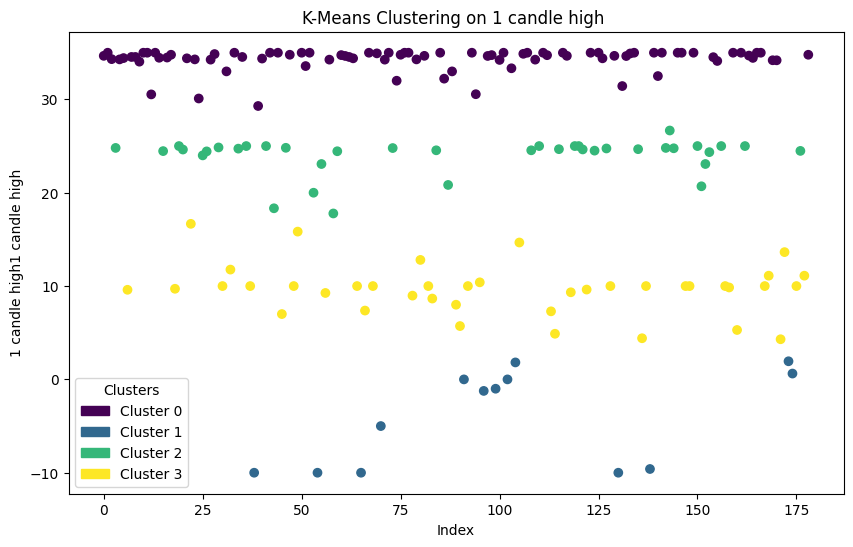

All model results saved to 'Doc//1 candle high_model_results.csv'.
Best model (RandomForest) saved to 'Doc//1 candle high_best_model.pkl' with F1 Score: 0.6862470862470862
Overall Accuracy: 0.9441340782122905
Overall Precision: 0.9224718381976447
Overall Recall: 0.9235323886639676
Overall F1 Score: 0.9205327900908011
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        88
           1       0.80      0.92      0.86        13
           2       0.97      0.92      0.95        38
           3       0.97      0.85      0.91        40

    accuracy                           0.94       179
   macro avg       0.92      0.92      0.92       179
weighted avg       0.95      0.94      0.94       179

[[88  0  0  0]
 [ 1 12  0  0]
 [ 2  0 35  1]
 [ 2  3  1 34]]




C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


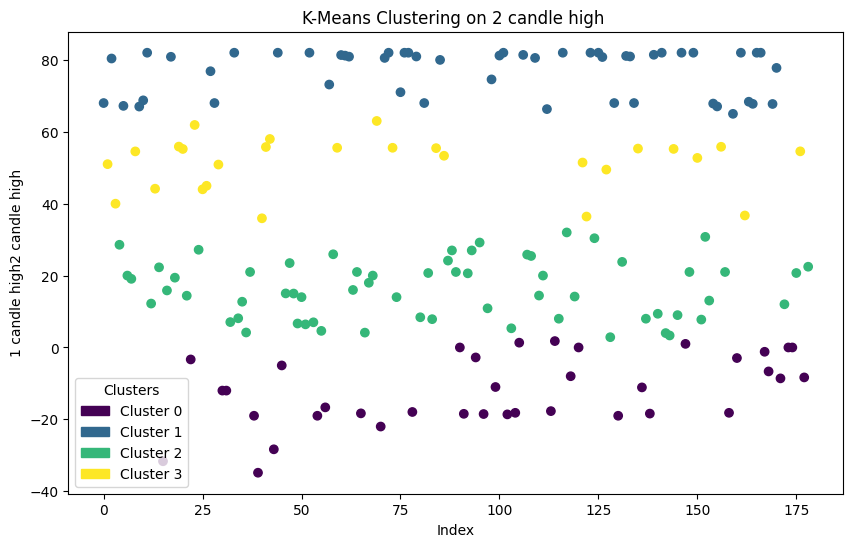

All model results saved to 'Doc//2 candle high_model_results.csv'.
Best model (RandomForest) saved to 'Doc//2 candle high_best_model.pkl' with F1 Score: 0.45503108003108006
Overall Accuracy: 0.8100558659217877
Overall Precision: 0.8336038961038961
Overall Recall: 0.7870569745569745
Overall F1 Score: 0.8013738481050829
              precision    recall  f1-score   support

           0       0.96      0.73      0.83        37
           1       0.74      0.94      0.83        52
           2       0.81      0.81      0.81        63
           3       0.82      0.67      0.73        27

    accuracy                           0.81       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.81      0.81       179

[[27  3  6  1]
 [ 0 49  3  0]
 [ 1  8 51  3]
 [ 0  6  3 18]]




C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


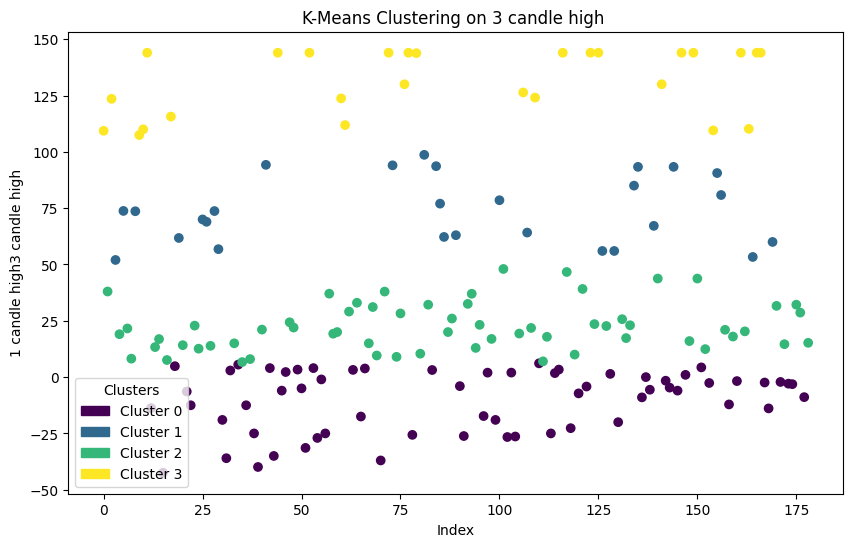

All model results saved to 'Doc//3 candle high_model_results.csv'.
Best model (RandomForest) saved to 'Doc//3 candle high_best_model.pkl' with F1 Score: 0.3796182266009852
Overall Accuracy: 0.888268156424581
Overall Precision: 0.8994888400130335
Overall Recall: 0.8832778631165727
Overall F1 Score: 0.8903686683006536
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        63
           1       0.96      0.85      0.90        27
           2       0.86      0.92      0.89        62
           3       0.89      0.89      0.89        27

    accuracy                           0.89       179
   macro avg       0.90      0.88      0.89       179
weighted avg       0.89      0.89      0.89       179

[[55  1  6  1]
 [ 2 23  2  0]
 [ 3  0 57  2]
 [ 2  0  1 24]]




C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


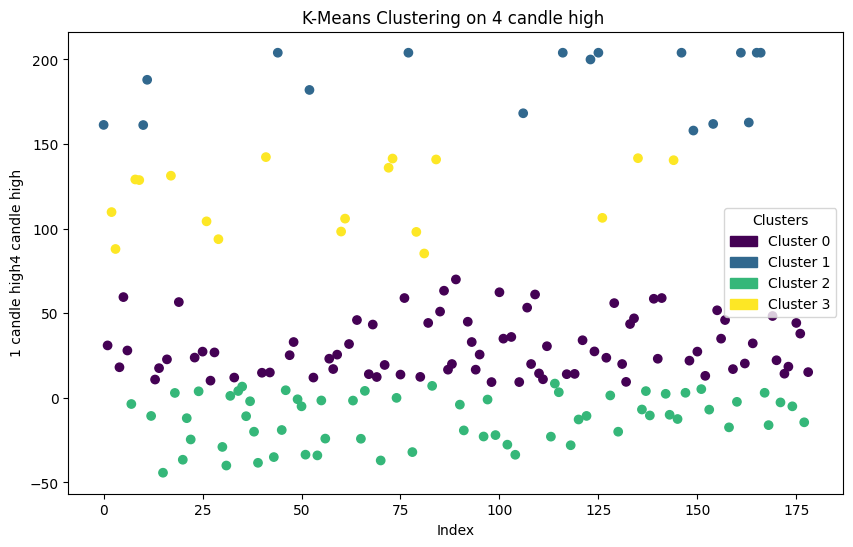

All model results saved to 'Doc//4 candle high_model_results.csv'.
Best model (DecisionTree) saved to 'Doc//4 candle high_best_model.pkl' with F1 Score: 0.3807359307359308
Overall Accuracy: 0.5810055865921788
Overall Precision: 0.4443233571893298
Overall Recall: 0.45735294117647063
Overall F1 Score: 0.4467681341441918
              precision    recall  f1-score   support

           0       0.56      0.74      0.63        80
           1       0.60      0.53      0.56        17
           2       0.62      0.56      0.59        64
           3       0.00      0.00      0.00        18

    accuracy                           0.58       179
   macro avg       0.44      0.46      0.45       179
weighted avg       0.53      0.58      0.55       179

[[59  5 16  0]
 [ 7  9  1  0]
 [28  0 36  0]
 [12  1  5  0]]




C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


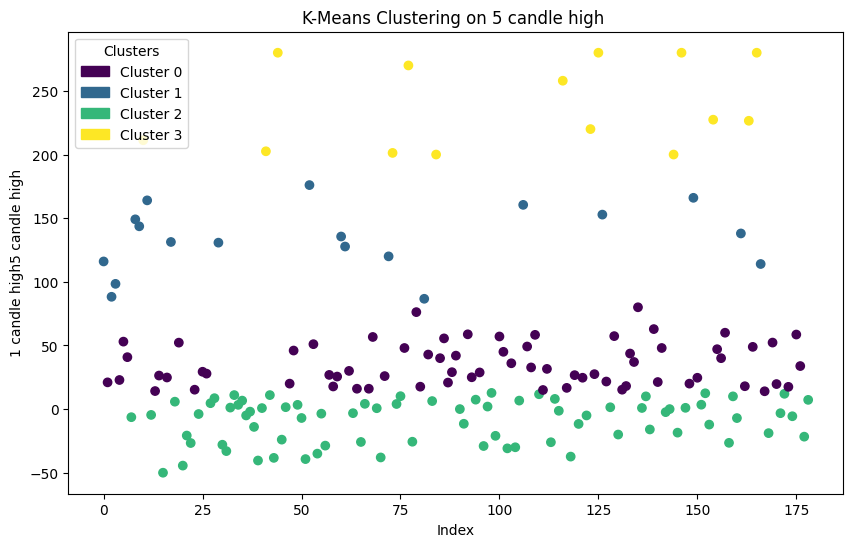

All model results saved to 'Doc//5 candle high_model_results.csv'.
Best model (RandomForest) saved to 'Doc//5 candle high_best_model.pkl' with F1 Score: 0.34959349593495936
Overall Accuracy: 0.6089385474860335
Overall Precision: 0.30400424787606195
Overall Recall: 0.3702619843924192
Overall F1 Score: 0.33378582202111606
              precision    recall  f1-score   support

           0       0.57      0.72      0.64        69
           1       0.00      0.00      0.00        18
           2       0.64      0.76      0.69        78
           3       0.00      0.00      0.00        14

    accuracy                           0.61       179
   macro avg       0.30      0.37      0.33       179
weighted avg       0.50      0.61      0.55       179

[[50  0 19  0]
 [ 7  0 11  0]
 [19  0 59  0]
 [11  0  3  0]]




In [16]:
for y in target.columns:
    if "high" in y :
        predict(y)

In [18]:
performance = {

}
for y in target.columns:
    if "high" in y :
        print(df[f"Cluster_{y}"].value_counts())
        min_cluster = df[f"Cluster_{y}"]
        performance.appen

Cluster_1 candle high
0    88
3    40
2    38
1    13
Name: count, dtype: int64
Cluster_2 candle high
2    63
1    52
0    37
3    27
Name: count, dtype: int64
Cluster_3 candle high
0    63
2    62
3    27
1    27
Name: count, dtype: int64
Cluster_4 candle high
0    80
2    64
3    18
1    17
Name: count, dtype: int64
Cluster_5 candle high
2    78
0    69
1    18
3    14
Name: count, dtype: int64
